In [1]:
import numpy as np
import h5py

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, Dropout,  Activation, Conv3D, MaxPooling3D, UpSampling3D, BatchNormalization, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import multi_gpu_model

from keras.optimizers import SGD
from keras.layers.merge import concatenate, add

#from keras.utils.io_utils import HDF5Matrix
from keras.utils import plot_model
from keras import optimizers


import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from random import shuffle

# STRUCTURE NETWORK 3D

In [3]:
def conv3d_block(input_tensor, filters, kernel_size, activation_fun = "linear"):
    # first layer
    x = Conv3D(filters=filters, kernel_size=kernel_size, kernel_initializer="he_normal", padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation_fun)(x)

    return x

kernel_size = (5,5,5)
act_fun = "relu"

############### DEFINE SET OF INPUTS #################

x = Input(shape=(8, 128, 128,3)) 


############## DEFINE PATH FOR INPUT 1 ##################


c1 = conv3d_block (x, filters=32, kernel_size=kernel_size, activation_fun = act_fun )
c1 = BatchNormalization()(c1)
p1 = MaxPooling3D (pool_size=(4, 8, 8), padding='valid')(c1)
p1 = Dropout(0.5)(p1)


c2 = conv3d_block(p1, filters=64, kernel_size=kernel_size, activation_fun = act_fun )
c2 = BatchNormalization()(c2)
p2 = MaxPooling3D(pool_size=(2, 4, 4), padding='valid')(c2)
p2 = Dropout(0.25)(p2)


p2 = Reshape((1024,))(p2)


d = Dense(2, activation = 'sigmoid')(p2)



model = Model(x , d)
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy())
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 128, 128, 3)]  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 128, 128, 32)   12032     
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 128, 128, 32)   128       
_________________________________________________________________
activation_2 (Activation)    (None, 8, 128, 128, 32)   0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 128, 128, 32)   128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 16, 16, 32)     0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 16, 16, 32)     0     

In [6]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, Directorio, batch_size = 5):
        
        self.batch_size = batch_size
        self.Directorio = h5py.File(Directorio)

    def __len__(self):
        
        return int((len(self.Directorio)/2) / self.batch_size)

    
    #Getitem nos devolvera los valores de X e Y para el indice de batch que le pida keras
    def __getitem__(self, index):
        
        #Creamos dos listas vacias en las que se separaran los valores de X e Y de nuestro archivo
        array_x = []
        array_y = []
        
        #Numero de ejemplos que tenemos en nuestro dataset, dividimos entre dos por que la longitud total
        #viene con el numero de X e Y
        self.indexes = np.arange(int(len(self.Directorio)/2))
        
        #dependiendo del indice de batch, indexes nos dara la posicion de los datos que queremos extraer
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        #Recorremos el directorio y extraemos las X con sus frames y las Y con sus estados
        for line in self.Directorio:

            if line[0] == 'X':
                array_x.append(self.Directorio[line])

            if line [0] == 'Y':
                array_y.append(self.Directorio[line])
        
        #dos nuevos listas en las que almacenaremos los datos correspondientes a las posiciones que nos pide
        #el indice del batch
        x = []
        y = []
        
        for i in indexes:
            x.append(array_x[i])
            y.append(array_y[i])
        
        #convertimos la lista anterior en un array con shape (batch_size,8,512,512,3)
        x_array = np.array(x)
        
        
        #Keras no entiende de strings, por lo que pasamos esos strings a vectores con numeros
        RE = [1,0] #vector para estado: reposo
        EA = [0,1] #vector para estado: ataque
        
        #lista donde almacenamos los vectores asociados a su string correspondiente
        y_strings = []
        
        for i in y:

            if i.value == 'RE':
                y_strings.append(RE)

            else:
                y_strings.append(EA)
                
        #convertimos la lista anterior en un array con shape (batch_size,2)
        y_array = np.array(y_strings)

        X, y = x_array,y_array

        return X,y

batch_size = 175


train_samples =  '/mnt/MD1200A/lconcha/videos/128x128/Datasets_training/Combinado_training'
test_samples =  '/mnt/MD1200A/lconcha/videos/128x128/Datasets_training/Combinado_validation'

training_generator   = DataGenerator(train_samples, batch_size )
validation_generator = DataGenerator(test_samples,  batch_size )

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


# COMPILE MODEL

In [8]:
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


history = model.fit_generator(generator=training_generator,
                    steps_per_epoch= int((len(h5py.File(train_samples))/2))// batch_size,
                    epochs=50,
                    verbose=True,
                    validation_data=validation_generator,
                    validation_steps=int((len(h5py.File(test_samples))/2))// batch_size,
                    use_multiprocessing=False,
                    workers=0,
                    max_queue_size=5)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7

Epoch 1/50
8/8 [==============================] - 712s 89s/step - loss: 1.4100 - accuracy: 0.5818 - val_loss: 4.6264 - val_accuracy: 0.4914
Epoch 2/50
8/8 [==============================] - 711s 89s/step - loss: 0.9764 - accuracy: 0.6397 - val_loss: 2.5037 - val_accuracy: 0.5543
Epoch 3/50
8/8 [==============================] - 707s 88s/step - loss: 0.8673 - accuracy: 0.6689 - val_loss: 2.2323 - val_accuracy: 0.5257
Epoch 4/50
8/8 [==============================] - 709s 89s/step - loss: 0.8227 - accuracy: 0.6516 - val_loss: 1.5651 - val_accuracy: 0.5400
Epoch 5/50
8/8 [==============================] - 708s 89s/step - loss: 0.8133 - accuracy: 0.6575 - val_loss: 1.2271 - val_accuracy: 0.5514
Epoch 6/50
8/8 [==============================] - 710s 89s/step - loss: 0.7625 - accuracy: 0.6950 - val_loss: 1.0752 - val_accuracy: 0.5771
Epoch 7/50
8/8 [==============================] - 709s 89s/step - loss: 0.7509 - accuracy: 0.6819 - val_loss: 1.0705 - val_accuracy: 0.5657
Epoch 8/50
8/8 [====

# SAVE MODEL

In [10]:
from keras.models import model_from_json

dirmodel = '/mnt/MD1200A/lconcha/videos/Modelos/2layers_dropout/'

# Guardar configuración JSON en el disco
model_json = model.to_json()
with open(dirmodel + "2layers_dropout.json", "w") as json_file:
    json_file.write(model_json)
# Guardar pesos en el disco
model.save_weights(dirmodel + "2layers_dropout.h5")
print("Saved model to disk")

Saved model to disk


# TESTING PREDICTIONS

In [12]:
test_samples = '/mnt/MD1200A/lconcha/videos/128x128/Datasets_training/Combinado_test'

#con esto vemos el numero de ejemplos que hay en el dataset de test
f = h5py.File(test_samples, 'r')
a_group_key = list(f.keys())
X_test = int(len(a_group_key)/2)


batch_size = X_test

test_generator = DataGenerator(test_samples, batch_size )

test_generator.batch_size = X_test
X, Y = test_generator.__getitem__(np.random.randint(0,1))
prediction = model.predict(X)

array_prediction = np.argmax(prediction, axis=1)
array_Y = np.argmax(Y, axis=1)

print(X.shape)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:58: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


(493, 8, 128, 128, 3)


# GONFUSION MATRIX AND GRAPHS

[[159  88]
 [ 17 229]]
     RE   EA
RE  159   88
EA   17  229


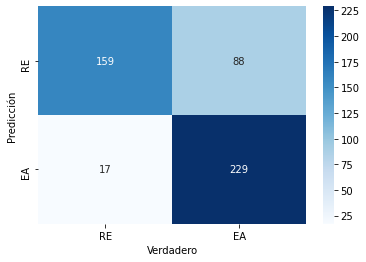

In [13]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

confm = confusion_matrix(array_Y,array_prediction)
print(confm)

columnas = ['RE','EA']
df_cm = pd.DataFrame(confm, index=columnas, columns=columnas)

print(df_cm)

grafica = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt="d")


plt.ylabel('Valores verdaderos')
plt.xlabel('Predicciones')
grafica.set(xlabel='Verdadero',ylabel='Predicción')
plt.show
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/2layers_dropout/confm_2layers_dropout.png', dpi = 500)

[[0.32251521 0.17849899]
 [0.03448276 0.46450304]]
          RE        EA
RE  0.322515  0.178499
EA  0.034483  0.464503


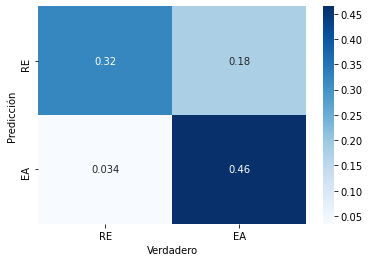

In [14]:
confm = confusion_matrix(array_Y,array_prediction)
confm = confm/493
print(confm)

columnas = ['RE','EA']
df_cm = pd.DataFrame(confm, index=columnas, columns=columnas)

print(df_cm)

grafica = sns.heatmap(df_cm, cmap='Blues', annot=True)


plt.ylabel('Valores verdaderos')
plt.xlabel('Predicciones')
grafica.set(xlabel='Verdadero',ylabel='Predicción')
plt.show
plt.savefig('/mnt/MD1200A/lconcha/videos//Modelos/2layers_dropout/percent_confm_2layers_dropout.png', dpi = 500)

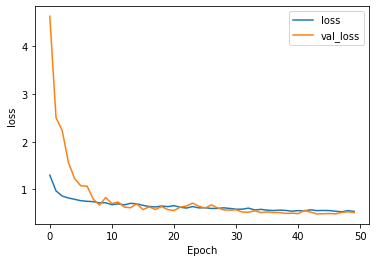

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/2layers_dropout/loss_2layers_dropout.png', dpi = 500)

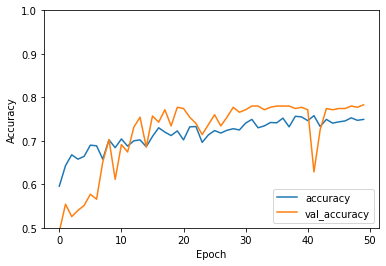

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/2layers_dropout/accuary_2layers_dropout.png', dpi = 500)

In [27]:
#Con el siguiente codigo guardo los arrays de la matriz de confusion, los valores de loss y val_loss

with open('/mnt/MD1200A/lconcha/videos/Modelos/2layers_dropout/2layers_dropout.npy', 'wb') as f:
    np.save(f, confm)
    np.save(f, history.history['loss'])
    np.save(f, history.history['val_loss'])
    
with open('/mnt/MD1200A/lconcha/videos/Modelos/2layers_dropout/2layers_dropout.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    c = np.load(f)
    
print(a, b,c)

[[0.29817444 0.20283976]
 [0.01014199 0.48884381]] [2.02828884 0.89261943 0.77637815 0.73262626 0.7352336  0.71549493
 0.67227149 0.66715801 0.67444861 0.65768361 0.65734583 0.60947871
 0.62901616 0.60750008 0.59852356 0.60899746 0.59207594 0.59757394
 0.56041545 0.56473994 0.56305569 0.55961519 0.55350357 0.56021708
 0.54680365 0.54485804 0.51904595 0.51499099 0.54043597 0.53410906
 0.50669742 0.49287191 0.48423532 0.4723492  0.49165249 0.47541204
 0.4906666  0.47868931 0.47513616 0.46743739 0.47820228 0.45908797
 0.46702716 0.45159057 0.46265286 0.46308628 0.45076895 0.43423757
 0.43307611 0.43894741 0.44391763 0.44169879 0.43807739 0.42200002
 0.40406355 0.41484275 0.42422068 0.41387668 0.41044033 0.41441542
 0.41023883 0.40384507 0.4088352  0.40638518 0.3831341  0.39323652
 0.41161847 0.39086077 0.39439777 0.3574867  0.37694162 0.38103116
 0.34822512 0.35870656 0.33125338 0.33229956 0.33612388 0.33920121
 0.33990052 0.33783427 0.32950047 0.34594929 0.34192184 0.34105855
 0.32877028